## Imports

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.models import Model
import os
import cv2
import shutil
from glob import glob
from pathlib import Path
import random

SEED = 42

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# cuDNN convolution (optional but recommended)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Functions

## F1 score function (from notebook 7)

In [30]:
# In Keras we have built in metrics
# We can also create custom metrics, such as F1 score
# Why don't we just use accuracy?
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1))) # threshold x >= 0.5 === 1, x <= 0.5 === 0
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # threshold x >= 0.5 === 1, x <= 0.5 === 0
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Dice coeficient

The F1 metric applies a hard 0.5 threshold to the predicted mask, so it cannot detect small improvements while the model is still learning. The Dice coefficient uses the continuous prediction values directly, making it more sensitive to gradual improvements in segmentation performance, especially in the early training stages.

[Dice-Sørensen coefficient](https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient)

In [31]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Plot loss

In [32]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

## Plot F1

In [33]:
def plot_f1(history):
    plt.figure()
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('Model F1 score')
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

# First iteration

### Reducing empty masks 

In [34]:
patch_dir = "../Task_4/dataset_patched"

train_img_root  = os.path.join(patch_dir, "train_images")   # e.g. train_images/train/...
train_mask_root = os.path.join(patch_dir, "train_masks")    # e.g. train_masks/train/...

IMAGE_EXT = ".png"
MASK_EXT  = ".tif"

REMOVED_IMG_ROOT  = os.path.join(patch_dir, "removed_images")
REMOVED_MASK_ROOT = os.path.join(patch_dir, "removed_masks")
os.makedirs(REMOVED_IMG_ROOT,  exist_ok=True)
os.makedirs(REMOVED_MASK_ROOT, exist_ok=True)

mask_paths = glob(os.path.join(train_mask_root, "**","" f"*{MASK_EXT}"), recursive=True)

non_empty = []
empty = []

for mpath in mask_paths:
    mpath = Path(mpath)
    mask = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    if np.sum(mask > 0) == 0:
        empty.append(mpath)
    else:
        non_empty.append(mpath)

print("Non-empty masks:", len(non_empty))
print("Empty masks:", len(empty))

max_empty_fraction = 0.25
max_empty_to_keep  = int(max_empty_fraction * len(non_empty))

random.shuffle(empty)
keep_empty   = empty[:max_empty_to_keep]
remove_empty = empty[max_empty_to_keep:]

print(len(remove_empty), f"empty patches will be removed")

moved_masks = 0
moved_imgs  = 0

for mpath in remove_empty:
    # Example: "train_Elavendan_232430_im4_root_mask_118.tif"
    stem = mpath.stem

    if "_root_mask_" not in stem:
        print("WARNING: unexpected mask name pattern:", stem)
        continue

    core, patch_idx = stem.split("_root_mask_")  # core="train_..._im4", patch_idx="118"

    image_filename = f"{core}_{patch_idx}{IMAGE_EXT}"  # "train_..._im4_118.png"

    # preserve subfolder structure relative to train_mask_root
    rel_mask = mpath.relative_to(train_mask_root)  # e.g. "train/train_..._root_mask_118.tif"
    rel_dir  = rel_mask.parent                     # e.g. "train"
    rel_img  = rel_dir / image_filename            # e.g. "train/train_..._im4_118.png"

    ipath = Path(train_img_root, rel_img)          # full image path

    dest_mask = Path(REMOVED_MASK_ROOT, rel_mask)
    dest_img  = Path(REMOVED_IMG_ROOT,  rel_img)

    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    dest_img.parent.mkdir(parents=True, exist_ok=True)

    # move mask
    if mpath.exists():
        shutil.move(str(mpath), str(dest_mask))
        moved_masks += 1

    # move image
    if ipath.exists():
        shutil.move(str(ipath), str(dest_img))
        moved_imgs += 1
    else:
        print("WARNING: image not found for mask:", mpath.name, "expected:", ipath)

print("Moved masks:", moved_masks)
print("Moved images:", moved_imgs)


Non-empty masks: 8707
Empty masks: 2176
0 empty patches will be removed
Moved masks: 0
Moved images: 0


## U-net model

In [35]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
    model.summary()
    
    return model

In [36]:
patch_size = 256

In [37]:
model = simple_unet_model(patch_size, patch_size, 3)

cb = EarlyStopping(monitor='val_f1',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_unet_model_patchsize256px.h5',
                             monitor='val_f1',
                             save_best_only=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

## Generator

#### Mask preprocess

In [38]:
def mask_preprocess(x):
    return (x > 0.5).astype('float32')

### Traing images/masks

In [39]:
batch_size = 16

# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator(preprocessing_function=mask_preprocess)

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 10883 images belonging to 1 classes.
Found 10883 images belonging to 1 classes.


### Validation images/masks

In [40]:
# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator(preprocessing_function=mask_preprocess)

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 6050 images belonging to 1 classes.
Found 6050 images belonging to 1 classes.


### Sanity check

Image range: 0.0 1.0
Mask range: 0.0 1.0


(-0.5, 255.5, 255.5, -0.5)

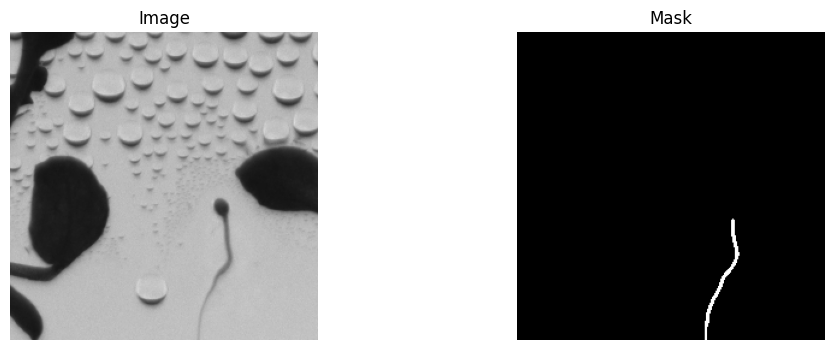

In [41]:
x_train_batch, y_train_batch = next(zip(train_image_generator, train_mask_generator))

print("Image range:", x_train_batch.min(), x_train_batch.max())
print("Mask range:", y_train_batch.min(), y_train_batch.max())

i = np.random.randint(0, x_train_batch.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].imshow(x_train_batch[i])
ax[0].set_title("Image"); ax[0].axis("off")

ax[1].imshow(y_train_batch[i].squeeze(), cmap='gray')
ax[1].set_title("Mask"); ax[1].axis("off")

## Train

In [42]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=100,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//batch_size,
    callbacks=[cb, checkpoint]
)

# steps_per_epoch=len(train_image_generator)

Epoch 1/100
271/681 [==========>...................] - ETA: 1:20 - loss: 0.1163 - f1: 0.0013

KeyboardInterrupt: 

### Checking results

In [ ]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0028991475701332092
Best validation f1: 0.45758694410324097


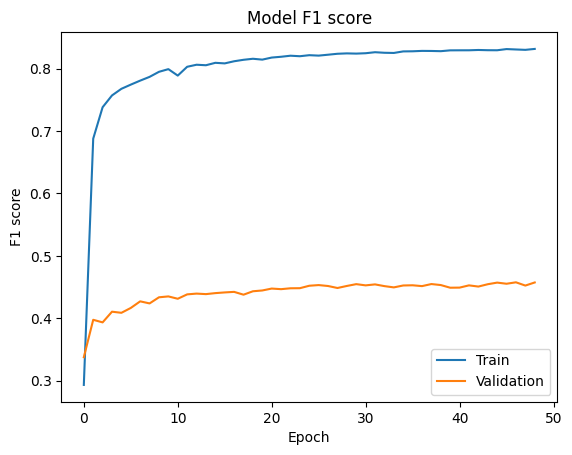

In [ ]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_f1(history)

In [ ]:
# preds = model.predict(val_image_generator, steps=val_image_generator.samples // batch_size)

378/378 [==============================] - 29s 77ms/step


1/1 [==============================] - 0s 37ms/step
Example index in batch: 1
Image range: 0.08235294 0.7411765
Mask range: 0.0 1.0
Mask range: 1.13884275e-11 0.99847823


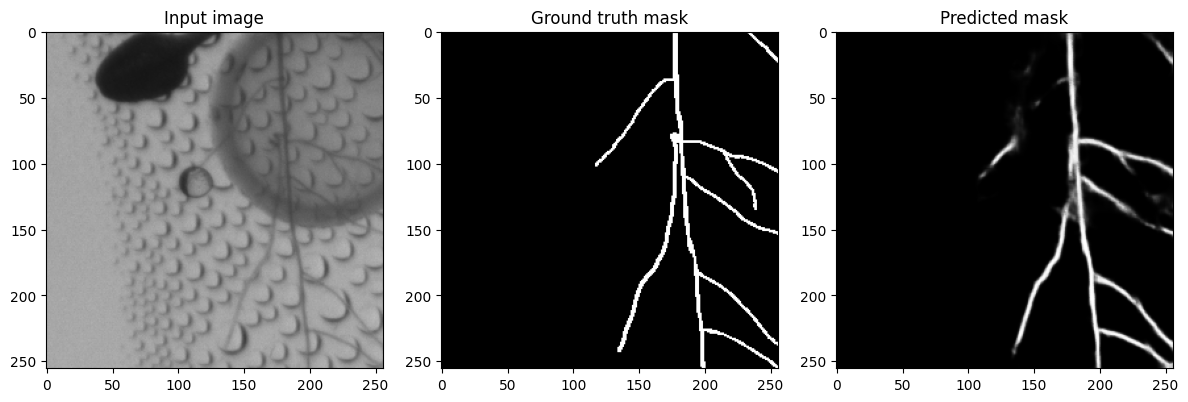

In [ ]:
x_val_batch, y_val_batch = next(zip(val_image_generator, val_mask_generator))


# Predict on that batch
pred_batch = model.predict(x_val_batch)


i = np.random.randint(0, x_val_batch.shape[0])
print("Example index in batch:", i)
print("Image range:", x_val_batch[i].min(), x_val_batch[i].max())
print("Mask range:", y_val_batch[i].min(), y_val_batch[i].max())
print("Mask range:", pred_batch[i].min(), pred_batch[i].max())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Image
ax[0].imshow(x_val_batch[i])
ax[0].set_title("Input image")

# True mask
ax[1].imshow(y_val_batch[i].squeeze(), cmap="gray")
ax[1].set_title("Ground truth mask")

# Predicted mask
ax[2].imshow(pred_batch[i].squeeze(), cmap="gray")
ax[2].set_title("Predicted mask")

plt.tight_layout()
plt.show()

# Multiclass Image Segmentation

## Empty mask reduction

In [2]:
patch_dir = "../Task_4/multiclass_dataset_patched"

train_img  = os.path.join(patch_dir, "train_images")   # e.g. train_images/train/...
train_mask = os.path.join(patch_dir, "train_masks")    # e.g. train_masks/train/...


IMAGE_EXT = ".png"
MASK_EXT  = ".tif"

REMOVED_IMG  = os.path.join(patch_dir, "removed_images")
REMOVED_MASK = os.path.join(patch_dir, "removed_masks")
os.makedirs(REMOVED_IMG,  exist_ok=True)
os.makedirs(REMOVED_MASK, exist_ok=True)

mask_paths = glob(os.path.join(train_mask, "**","" f"*{MASK_EXT}"), recursive=True)

non_empty = []
empty = []

for mpath in mask_paths:
    mpath = Path(mpath)
    mask = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    if np.sum(mask > 0) == 0:
        empty.append(mpath)
    else:
        non_empty.append(mpath)

print("Non-empty masks:", len(non_empty))
print("Empty masks:", len(empty))

max_empty_fraction = 0.25
max_empty_to_keep  = int(max_empty_fraction * len(non_empty))

random.shuffle(empty)
keep_empty   = empty[:max_empty_to_keep]
remove_empty = empty[max_empty_to_keep:]

print(len(remove_empty), f"empty patches will be removed")

moved_masks = 0
moved_imgs  = 0

for mpath in remove_empty:
    # Example: "train_Elavendan_232430_im4_root_mask_118.tif"
    stem = mpath.stem

    if "_mask_" not in stem:
        print("WARNING: unexpected mask name pattern:", stem)
        continue

    core, patch_idx = stem.split("_mask_")  # core="train_..._im4", patch_idx="118"

    image_filename = f"{core}_{patch_idx}{IMAGE_EXT}"  # "train_..._im4_118.png"

    # preserve subfolder structure relative to train_mask_root
    rel_mask = mpath.relative_to(train_mask)  # e.g. "train/train_..._root_mask_118.tif"
    rel_dir  = rel_mask.parent                     # e.g. "train"
    rel_img  = rel_dir / image_filename            # e.g. "train/train_..._im4_118.png"

    ipath = Path(train_img, rel_img)          # full image path

    dest_mask = Path(REMOVED_MASK, rel_mask)
    dest_img  = Path(REMOVED_IMG,  rel_img)

    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    dest_img.parent.mkdir(parents=True, exist_ok=True)

    # move mask
    if mpath.exists():
        shutil.move(str(mpath), str(dest_mask))
        moved_masks += 1

    # move image
    if ipath.exists():
        shutil.move(str(ipath), str(dest_img))
        moved_imgs += 1
    else:
        print("WARNING: image not found for mask:", mpath.name, "expected:", ipath)
        
num_masks = len(mask_paths)
print("Total mask patches :", num_masks)
print("Moved masks:", moved_masks)
print("Moved images:", moved_imgs)

Non-empty masks: 10544
Empty masks: 2636
0 empty patches will be removed
Total mask patches : 13180
Moved masks: 0
Moved images: 0


## Set generator

In [ ]:
import glob
X_train = []
y_train = []
for im_path in glob.glob(f'{patch_dir}/train_images/train/*.png'):
    mask_path = im_path.replace('images', 'masks')
    mask_path = im_path.replace('*.png', '*.tif')
    im = cv2.imread(im_path)
    mask = cv2.imread(mask_path, 0)
    X_train.append(im)
    y_train.append(mask)

X_val = []
y_val = []
for im_path in glob.glob(f'{patch_dir}/val_images/val/*.png'):
    mask_path = im_path.replace('images', 'masks')
    mask_path = im_path.replace('*.png', '*.tif')
    im = cv2.imread(im_path)
    mask = cv2.imread(mask_path, 0)
    X_val.append(im)
    y_val.append(mask)

TypeError: '<' not supported between instances of 'list' and 'int'

In [4]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((13180, 256, 256, 3),
 (13180, 256, 256),
 (6050, 256, 256, 3),
 (6050, 256, 256))

In [5]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_train.shape, y_val.shape

IndexError: index 198 is out of bounds for axis 1 with size 4

In [423]:
patch_size = 256
batch_size = 16
n_classes = 4

In [424]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

def custom_generator(dataset_type, batch_size, target_size):

    img_dir  = f'{patch_dir}/{dataset_type}_images'
    mask_dir = f'{patch_dir}/{dataset_type}_masks'

    # Count
    img_paths  = glob(os.path.join(img_dir, '**', '*.png'), recursive=True)
    mask_paths = glob(os.path.join(mask_dir, '**', '*.tif'), recursive=True)

    num_img = len(img_paths)
    num_masks = len(mask_paths)
    print(f"[INFO] {dataset_type}: {len(img_paths)} images, {len(mask_paths)} masks")


    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_images',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        seed=42)

    mask_generator = mask_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_masks',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        color_mode='grayscale',
        seed=42)
    
    # Here I can add the to_categorical part
    def gen():
        while True:
            X = image_generator.next()
            Y = mask_generator.next()
            Y = to_categorical(Y.squeeze(-1), num_classes=4)
            yield X, Y

    g = gen()

    return g, num_img, num_masks

In [425]:
train_gen, t_img, t_masks = custom_generator('train', batch_size=16, target_size=(patch_size,patch_size))
val_gen, v_img, v_masks  = custom_generator('val', batch_size=16, target_size=(patch_size,patch_size))

[INFO] train: 13180 images, 13180 masks
Found 13180 images belonging to 1 classes.
Found 13180 images belonging to 1 classes.
[INFO] val: 6050 images, 6050 masks
Found 6050 images belonging to 1 classes.
Found 6050 images belonging to 1 classes.


### Model

In [426]:
# *AlMOST* SAME AS NOTEBOOK 7
# Diff 1: output layer Conv2D(n_classes, (1, 1), activation='softmax')(c9)
# Diff 2: loss='categorical_crossentropy'
# Diff 3: multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes): # changed
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9) # changed
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1]) # changed
    model.summary()
    
    return model

### Training

In [427]:
model = multiclass_unet_model(patch_size, patch_size, 3, n_classes)

cb = EarlyStopping(monitor='val_f1',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_multiclass_unet_model_patchsize256px.h5',
                             monitor='val_loss',
                             save_best_only=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 256, 256, 16  448         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_63 (Dropout)           (None, 256, 256, 16  0           ['conv2d_133[0][0]']             
                                )                                                           

In [428]:
history = model.fit(
    train_gen,
    steps_per_epoch=t_img//batch_size,
    epochs=100,
    validation_data = val_gen,
    validation_steps = v_img//batch_size,
    callbacks=[cb, checkpoint]
)

Epoch 1/100
823/823 [==============================] - 217s 261ms/step - loss: 1.2689 - f1: 0.9566 - val_loss: 0.0289 - val_f1: 0.9907
Epoch 2/100
823/823 [==============================] - 215s 261ms/step - loss: 0.0848 - f1: 0.9719 - val_loss: 0.0208 - val_f1: 0.9928
Epoch 3/100
823/823 [==============================] - 213s 259ms/step - loss: 0.0633 - f1: 0.9772 - val_loss: 0.0126 - val_f1: 0.9956
Epoch 4/100
823/823 [==============================] - 213s 259ms/step - loss: 0.0462 - f1: 0.9842 - val_loss: 0.0136 - val_f1: 0.9954
Epoch 5/100
823/823 [==============================] - 213s 259ms/step - loss: 0.0428 - f1: 0.9855 - val_loss: 0.0115 - val_f1: 0.9963
Epoch 6/100
823/823 [==============================] - 212s 258ms/step - loss: 0.0373 - f1: 0.9875 - val_loss: 0.0082 - val_f1: 0.9973
Epoch 7/100
823/823 [==============================] - 212s 258ms/step - loss: 0.0335 - f1: 0.9886 - val_loss: 0.0068 - val_f1: 0.9977
Epoch 8/100
823/823 [==============================] - 

In [430]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.003974025137722492
Best validation f1: 0.9985540509223938


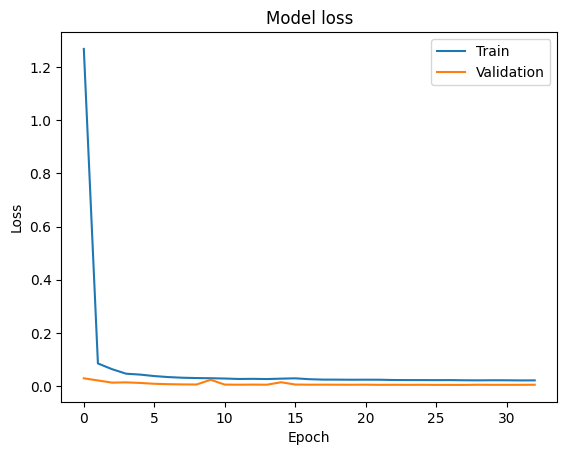

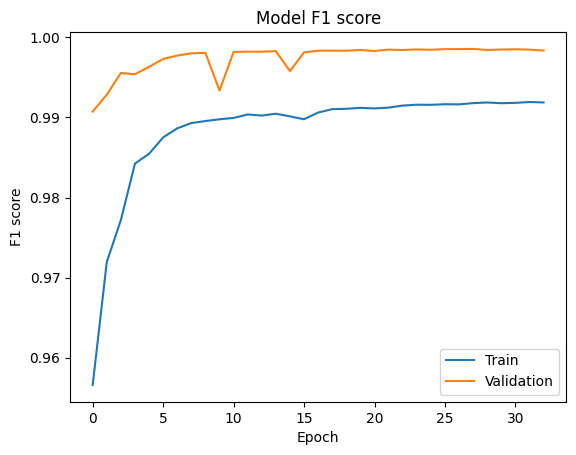

In [429]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_f1(history)

In [19]:
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'maciej_czerniak_243552_multiclass_unet_model_patchsize{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [22]:
X_val_2 = X_val[:16]
predicted_masks = model.predict(X_val_2)

1/1 [==============================] - 1s 1s/step


In [17]:
print("X_val shape:", X_val[0].shape)

X_val shape: (256, 256, 3)


In [20]:
predicted_masks = model.predict(X_val[0])

ValueError: in user code:

    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "s:\GitHub\2025-26b-fai2-adsai-MaciejCzerniak243552\Y2B\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_7" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 256, 3)


In [29]:
i = 0
prediction = np.argmax(predicted_masks[i], axis=2)
ground_truth = np.argmax(y_val[i], axis=2)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_val[i])
ax[1].imshow(ground_truth)
ax[2].imshow(prediction)

AxisError: axis 2 is out of bounds for array of dimension 2